# Make new taylor plots (with both CAM6 and updated observations)

### Here, I am using the updated set of observations and copying all needed files to a single directory for organizations and reproducibility. I am also using a bilinear (linear?) interpolation instead of a nearest neighbor interpolation.

Verify my methods by reproducing Figure 7 from Kay 2012 using the stored data from Ben Hillman.

### Function and package imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    mpl,glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

import cftime

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Taylor plot specific imports

In [2]:
import taylor_jshaw as taylor
import matplotlib as matplotlib
import matplotlib.patches as patches

In [3]:
from interp_functions import *
from functions import calculate

### Label appropriate directories

#### I am reorganizing to have everything in this first directory

In [4]:
# where to save processed files
save_dir = '/glade/u/home/jonahshaw/w/archive/taylor_files/'

# Old processing here 

In [6]:
# _ceres_data = xr.open_dataset('/glade/work/jonahshaw/obs/CERES/CERES_EBAF-TOA_Ed4.1_Subset_200003-202102.nc')
# _ceres_data = add_weights(_ceres_data)
# # Flip FLNSC so it matches model convention (net-LW is down, net-SW is up)
# # _ceres_data['sfc_net_lw_clr_t_mon'] = -1*_ceres_data['sfc_net_lw_clr_t_mon']

# # Derive Cloud Radiative Effect Variables
# _ceres_data['SWCF'] = (_ceres_data['toa_sw_clr_c_mon'] - _ceres_data['toa_sw_all_mon']).assign_attrs(
#     {'units': 'W/m2','long_name': 'Shortwave cloud forcing'})
# _ceres_data['LWCF'] = (_ceres_data['toa_lw_clr_c_mon'] - _ceres_data['toa_lw_all_mon']).assign_attrs(
#     {'units': 'W/m2','long_name': 'Longwave cloud forcing'})

# _ceres_data['SWCF'].to_netcdf('%s/2021_obs/CERES_SWCF_200003_202102.nc' % save_dir)

# _ceres_data['LWCF'].to_netcdf('%s/2021_obs/CERES_LWCF_200003_202102.nc' % save_dir)

In [77]:
# # original observations from the Kay 2012 paper
# # og_dir = '/glade/u/home/jonahshaw/w/kay2012_OGfiles'

# # CAM4 and CAM5 model runs
# oldcase_dir = '/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012/'
# # CAM6 model runs
# newcase_dir = '/glade/p/cesm/pcwg/jenkay/COSP/cesm21/'

# # Time ranges to select by:
# time_range1 = ['2001-01-01', '2010-12-31']
# time_range2 = ['0001-01-01', '0010-12-31']

# _ceres_data = xr.open_dataset('/glade/u/home/jonahshaw/obs/CERES_EBAF/CERES_EBAF-TOA_Ed4.1_Subset_200003-202002.nc')
# #         _ceres_data = _ceres_data.sel(time=slice('2000-01-01', '2015-12-31')) # This was a problem.
# _ceres_data = add_weights(_ceres_data)
# # Flip FLNSC so it matches model convention (net-LW is down, net-SW is up)
# #         _ceres_data['sfc_net_lw_clr_t_mon'] = -1*_ceres_data['sfc_net_lw_clr_t_mon']

# # Derive Cloud Radiative Effect Variables
# _ceres_data['SWCF'] = (_ceres_data['toa_sw_clr_c_mon'] - _ceres_data['toa_sw_all_mon']).assign_attrs(
#     {'units': 'W/m2','long_name': 'Shortwave cloud forcing'})
# _ceres_data['LWCF'] = (_ceres_data['toa_lw_clr_c_mon'] - _ceres_data['toa_lw_all_mon']).assign_attrs(
#     {'units': 'W/m2','long_name': 'Longwave cloud forcing'})

# _ceres_data['SWCF'].to_netcdf('%s/2021_obs/CERES_SWCF_2000_2020.nc' % save_dir)

# # _ceres_data['LWCF'].to_netcdf('%s/2021_obs/CERES_LWCF_2000_2020.nc' % save_dir)

# BLANK 

In [5]:
# case_dirs = [oldcase_dir,oldcase_dir,newcase_dir]
# cases = [
#     '%s%s' % (oldcase_dir,'cam4_1deg_release_amip'),
#     '%s%s' % (oldcase_dir,'cam5_1deg_release_amip'),
#     '%s%s' % (newcase_dir,'f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1')    
# ]
cases = [
    'cam4_1deg_release_amip',
    'cam5_1deg_release_amip',
    'f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1'   
]

cosp_v = [1,1,2] # cosp version (guess)

In [6]:
def get_file(var_name,case,suffix=''):
    return glob.glob('%s/%s/*%s*.nc' % (case,suffix,var_name))

In [7]:
def fix_cam_time(ds):
    try:
        ds['time'] = ds['time_bnds'].isel(bnds=0)
    except:
        ds['time'] = ds['time_bnds'].isel(nbnd=0)
        
    return ds

In [8]:
def select_AMIP(ds):
    
    if ds['time.year'][0] > 1000: # bad way to discriminate by year format
        _ds = ds.sel(time=slice('2001-01-01', '2010-12-31')) # work for the AMIP 0000-0010
    else:
        _ds = ds.sel(time=slice('0001-01-01', '0010-12-31')) # work for the AMIP 0000-0010
    
    return _ds

## Panel 1 (CERES-EBAF LWCF and SWCF)

### Open observation files

In [9]:
new_swcf = xr.open_dataset('%s/2021_obs/CERES_SWCF_200003_202102.nc' % (save_dir))
new_lwcf = xr.open_dataset('%s/2021_obs/CERES_LWCF_200003_202102.nc' % (save_dir))

proc_swcf = new_swcf.groupby('time.month').mean('time').mean('month')
proc_lwcf = new_lwcf.groupby('time.month').mean('time').mean('month')

cntlnames = {
        'SWCF': proc_swcf['SWCF'], # these have to be dataarrays, not datasets
        'LWCF': proc_lwcf['LWCF'],
        }

### Open model files

In [10]:
_vars = ['SWCF','LWCF']
suffix = 'atm/proc/tseries/month_1'

model_das = {}
for j in _vars:
    var_files = []
    for ii in cases:
        _f = glob.glob('%s/%s/*%s*.nc' % (save_dir,ii,j)) # get the correct file
#         print(_f)
#         break
        # open dataset
        _ds = xr.open_dataset(_f[0])
        print(_f[0])
        # apply time bounds  
        _ds = fix_cam_time(_ds)
        # select the AMIP period
        _ds = select_AMIP(_ds)
        # Fix any weird month/year mismatch by weighting months equally.
        _da = _ds[j].groupby('time.month').mean('time').mean('month')
        # Interpolate to the control (observation) grid
#         _da = _da.interp_like(cntlnames[j],method='nearest')
#         _da = _da.interp_like(cntlnames[j])
        _da,_rgrd = interp_like2D(_da,target=cntlnames[j])
    
#         var_files.append(_da)
        var_files.append(_da[j])
#         print(_f)
    model_das[j] = var_files

testmetrics = model_das

/glade/u/home/jonahshaw/w/archive/taylor_files//cam4_1deg_release_amip/cam4_1deg_release_amip.cam.h0.SWCF.200011-201012.nc
/glade/u/home/jonahshaw/w/archive/taylor_files//cam5_1deg_release_amip/cam5_1deg_release_amip.cam.h0.SWCF.200101-201012.nc
/glade/u/home/jonahshaw/w/archive/taylor_files//f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.cam.h0.SWCF.197901-201412.nc
/glade/u/home/jonahshaw/w/archive/taylor_files//cam4_1deg_release_amip/cam4_1deg_release_amip.cam.h0.LWCF.200011-201012.nc
/glade/u/home/jonahshaw/w/archive/taylor_files//cam5_1deg_release_amip/cam5_1deg_release_amip.cam.h0.LWCF.200101-201012.nc
/glade/u/home/jonahshaw/w/archive/taylor_files//f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.cam.h0.LWCF.197901-201412.nc


### Calculate

In [11]:
testnames = ('CAM4','CAM5','CAM6')
varnames = ['SWCF','LWCF']

nvars = 2; ntest = 3;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric #[var]
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio,_bias_abs = calculate(obs_ds,test_ds)
#         print(_bias[var],_corr[var],_rmsnorm[var],_ratio[var])
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

### Plot

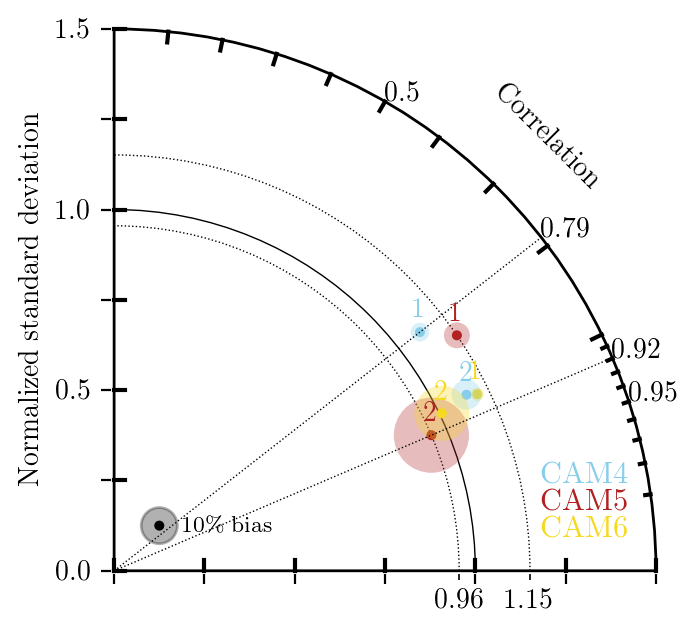

In [12]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick','#f6d921')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False

## Panel 2 (ISCCP, MISR, and CALIPSO total cloud)

### BLANK

I have to shift the time coordinate, because it is off by a month. I centered it at th 15th so there is no future confusion.

In [86]:
# new_time = cftime.num2date(range(243), 'months since 2000-03-15', '360_day')

# misr_dir = '/glade/work/jonahshaw/obs/MISR/'
# misr_monthly_file = 'clt_MISR_20000301_20200531.nc'
# misr_monthly = xr.open_dataset('%s/%s' % (misr_dir,misr_monthly_file))

# misr_monthly['time'] = new_time
# misr_monthly = misr_monthly.rename({'clMISR':'cltMISR'})

# misr_monthly['cltMISR'].to_netcdf('%s/2021_obs/MISR_CLDTOT_200003_202005.nc' % save_dir)

og_caliop_dir = '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/'

all_caliopf = glob.glob('%s/**/*' % og_caliop_dir)

# # len(all_caliop)
all_caliopf.sort()

# check1 = xr.open_dataset(bob[0])
# check2 = xr.open_dataset(bob[11])

# check1

bob = [i for i in all_caliopf if '2017' in i]

# test1 = xr.open_mfdataset(bob,combine='by_coords')

# all_cal = xr.open_mfdataset(all_caliopf,combine='by_coords')

# all_cal

# all_cal['cltcalipso'].to_netcdf('%s/2021_obs/CALIOP_CLDTOT_200606_201512.nc' % save_dir)
# all_cal['cllcalipso'].to_netcdf('%s/2021_obs/CALIOP_CLDLOW_200606_201512.nc' % save_dir)
# all_cal['clmcalipso'].to_netcdf('%s/2021_obs/CALIOP_CLDMED_200606_201512.nc' % save_dir)
# all_cal['clhcalipso'].to_netcdf('%s/2021_obs/CALIOP_CLDHGH_200606_201512.nc' % save_dir)

# all_cal['cltcalipso_liq'].to_netcdf('%s/2021_obs/CALIOP_CLDTOTLIQ_200606_201512.nc' % save_dir)
# all_cal['cltcalipso_ice'].to_netcdf('%s/2021_obs/CALIOP_CLDTOTICE_200606_201512.nc' % save_dir)

In [87]:
bob

['/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/2017/MapLowMidHigh330m_201701_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/2017/MapLowMidHigh330m_201702_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/2017/MapLowMidHigh330m_201703_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/2017/MapLowMidHigh330m_201704_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/2017/MapLowMidHigh330m_201705_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/2017/MapLowMidHigh330m_201706_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/2017/MapLowMidHigh330m_201707_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/2017/MapLowMidHigh330m_201708_avg_CFMIP2_sat_3.1.2.nc',
 '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_2x

### BLANK

### Open files

In [13]:
new_clt_isccp = xr.open_dataset('%s/2021_obs/ISCCP_CLDTOT_199807_201612.nc' % (save_dir))
new_clt_misr = xr.open_dataset('%s/2021_obs/MISR_CLDTOT_200003_202005.nc' % (save_dir))
new_clt_caliop = xr.open_dataset('%s/2021_obs/CALIOP_CLDTOT_200606_201512.nc' % (save_dir))

proc_clt_isccp = new_clt_isccp.groupby('time.month').mean('time').mean('month')
# proc_clt_misr = new_clt_misr.groupby('time.month').mean('time').mean('month')
proc_clt_caliop = 100*new_clt_caliop.groupby('time.month').mean('time').mean('month')

proc_clt_isccp = proc_clt_isccp.rename({'cltisccp':'CLDTOT_ISCCP'})
proc_clt_misr = new_clt_misr.rename({'clMISR':'CLDTOT_MISR'})
proc_clt_caliop = proc_clt_caliop.rename({'cltcalipso':'CLDTOT_CAL'}) # yes, this is on a 2x2deg grid

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [89]:
# proc_clt_misr = xr.open_dataset('%s/2012_obs/MISR.CLDTOT_MISR.nc' % save_dir)


### Create mask for ISCCP and MISR

Apparently for the land masking I need to use each model's separate LANDFRAC variable.

In [19]:
landfrac_cam4 = xr.open_dataset('%s/%s/%s.cam.h0.LANDFRAC.200011-201012.nc' % (save_dir,cases[0],cases[0]))['LANDFRAC']
landfrac_cam5 = xr.open_dataset('%s/%s/%s.cam.h0.LANDFRAC.200101-201012.nc' % (save_dir,cases[1],cases[1]))['LANDFRAC']
landfrac_cam6 = xr.open_dataset('%s/%s/%s.cam.h0.LANDFRAC.197901-201412.nc' % (save_dir,cases[2],cases[2]))['LANDFRAC']

landfracs = [landfrac_cam4,landfrac_cam5,landfrac_cam6]

In [20]:
# despite the same gridding, it doesn't work if I apply the same mask for all of them
model_masks = {}

for _lf,_case in zip(landfracs,cases):
    _lf2 = _lf.mean('time')
    
#     misr_mask = np.bitwise_and(_lf2 < 0.2,np.abs(_lf2['lat'])<60) #.plot()
    misr_mask = (np.abs(_lf2['lat'])<60)

    isccp_mask = (np.abs(_lf2['lat'])<60)
    
    clt_masks = {'CLDTOT_ISCCP':isccp_mask,'CLDTOT_MISR':misr_mask,'CLDTOT_CAL':None}
    
    model_masks[_case] = clt_masks

### Open model files

In [21]:
# Pre-proc for MISR obs
clt_misr1 = proc_clt_misr['CLDTOT_MISR'].assign_coords(lon=(proc_clt_misr['CLDTOT_MISR'].lon % 360)).sortby('lon')
clt_misr2 = xr.where(clt_misr1 == 0,np.nan,clt_misr1)

# Necessary pre-processing for CALIOP obs when using interp_like
clt_cal1 = proc_clt_caliop['CLDTOT_CAL'].rename({'longitude':'lon','latitude':'lat'})
clt_cal2 = clt_cal1.assign_coords(lon=(clt_cal1.lon % 360)).sortby('lon')

In [22]:
cntlnames = {
        'CLDTOT_ISCCP': proc_clt_isccp['CLDTOT_ISCCP'], # these have to be dataarrays, not datasets
        'CLDTOT_MISR': clt_misr2,#.where(np.abs(clt_misr1['lat'])<60),
        'CLDTOT_CAL': clt_cal2,
    }

In [23]:
_vars = ['CLDTOT_ISCCP','CLDTOT_MISR','CLDTOT_CAL']

model_das = {}
for j in _vars:
    print(j)
    var_files = []
    for ii in cases:
        print(ii)
        _f = glob.glob('%s/%s/*.%s.*' % (save_dir,ii,j)) # get the correct file
        # open dataset
#         print(_f[0])
        _ds = xr.open_dataset(_f[0])
        # Fix any weird month/year mismatch by weighting months equally.
        try:
            _ds = fix_cam_time(_ds)
        except:
            print('Check that time is already selected.')
            pass
        # select the AMIP period
        _ds = select_AMIP(_ds)
        # Fix any weird month/year mismatch by weighting months equally.
        _da = _ds[j].groupby('time.month').mean('time').mean('month')
        
        _clt_mask = model_masks[ii]
        if _clt_mask[j] is not None: # handles the no mask case
            _da = _da.where(_clt_mask[j])
        # Interpolate to the control (observation) grid
#         _da = _da.interp_like(cntlnames[j],method='nearest')
#         print(cntlnames[j])
#         print(cntlnames[j].shape, _da.shape)
#         try:
#             _da = _da.interp_like(cntlnames[j])
#         except:
#             print('error')
#             print('da: ',_da)
#             print('cntlnames[j]: ',cntlnames[j])
#             break
        _da,_rgrd = interp_like2D(_da,target=cntlnames[j]) # this should return a da if given a da
#         print(_da.name)
#         var_files.append(_da)
        var_files.append(_da[j])
    model_das[j] = var_files

testmetrics = model_das

CLDTOT_ISCCP
cam4_1deg_release_amip


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


cam5_1deg_release_amip
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1
CLDTOT_MISR
cam4_1deg_release_amip
cam5_1deg_release_amip
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1
CLDTOT_CAL
cam4_1deg_release_amip
cam5_1deg_release_amip
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1


### Calculate

Add MISR masking

In [95]:
# test0 = testmetrics['CLDTOT_MISR'][0]#.interp_like(cntl)
# test1 = testmetrics['CLDTOT_MISR'][1]#.interp_like(cntl)
# test2 = testmetrics['CLDTOT_MISR'][2]#.interp_like(cntl)
# cntl = cntlnames['CLDTOT_MISR']#.interp_like(test)

#### These are not being masked correctly. Should just use values below 60degrees.

In [24]:
testnames = ('CAM4','CAM5','CAM6')
varnames = ['CLDTOT_ISCCP','CLDTOT_MISR','CLDTOT_CAL']

nvars = 3; ntest = 3;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric #[var]
#         print('test_ds shape: ',test_ds.shape)
#         print('obs_ds shape: ',obs_ds.shape)
        

        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio,_bias_abs = calculate(obs_ds,test_ds)
#         print(_bias[var],_corr[var],_rmsnorm[var],_ratio[var])
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

### Plot

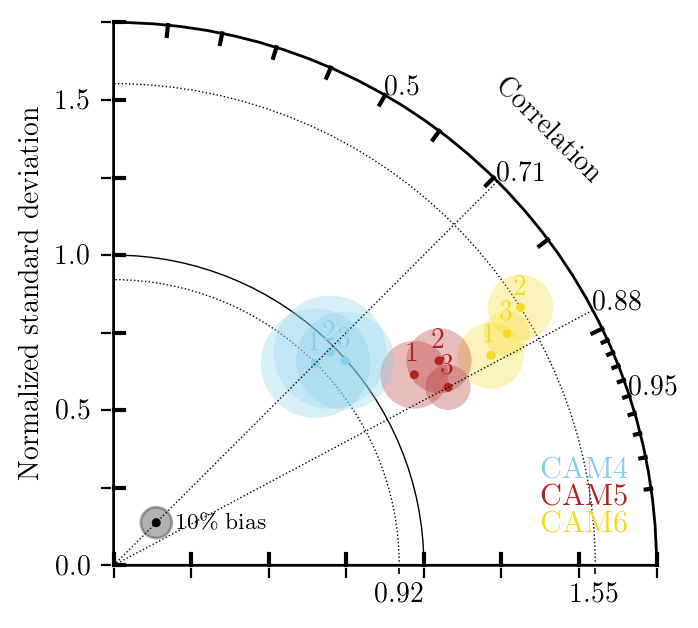

In [25]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick','#f6d921')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False

## Panel 3 (CALIPSO low- mid- and high-level cloud)

### Open files

In [26]:
new_cldlow_cal = xr.open_dataset('%s/2021_obs/CALIOP_CLDLOW_200606_201512.nc' % (save_dir))
new_cldmed_cal = xr.open_dataset('%s/2021_obs/CALIOP_CLDMED_200606_201512.nc' % (save_dir))
new_cldhgh_cal = xr.open_dataset('%s/2021_obs/CALIOP_CLDHGH_200606_201512.nc' % (save_dir))

proc_cldlow_cal = 100*new_cldlow_cal.groupby('time.month').mean('time').mean('month')
proc_cldmed_cal = 100*new_cldmed_cal.groupby('time.month').mean('time').mean('month')
proc_cldhgh_cal = 100*new_cldhgh_cal.groupby('time.month').mean('time').mean('month')

proc_cldlow_caliop = proc_cldlow_cal.rename({'cllcalipso':'CLDLOW_CAL'}) # yes, this is on a 2x2deg grid
proc_cldmed_caliop = proc_cldmed_cal.rename({'clmcalipso':'CLDMED_CAL'}) # yes, this is on a 2x2deg grid
proc_cldhgh_caliop = proc_cldhgh_cal.rename({'clhcalipso':'CLDHGH_CAL'}) # yes, this is on a 2x2deg grid

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [27]:
# Necessary pre-processing for CALIOP obs when using interp_like
cll1 = proc_cldlow_caliop['CLDLOW_CAL'].rename({'longitude':'lon','latitude':'lat'})
cll2 = cll1.assign_coords(lon=(cll1.lon % 360)).sortby('lon')

clm1 = proc_cldmed_caliop['CLDMED_CAL'].rename({'longitude':'lon','latitude':'lat'})
clm2 = clm1.assign_coords(lon=(clm1.lon % 360)).sortby('lon')

clh1 = proc_cldhgh_caliop['CLDHGH_CAL'].rename({'longitude':'lon','latitude':'lat'})
clh2 = clh1.assign_coords(lon=(clh1.lon % 360)).sortby('lon')

### Open model files

In [28]:
cntlnames = {
        'CLDLOW_CAL': cll2, # these have to be dataarrays, not datasets
        'CLDMED_CAL': clm2,
        'CLDHGH_CAL': clh2,
    }

In [29]:
_vars = ['CLDLOW_CAL','CLDMED_CAL','CLDHGH_CAL']
suffix = 'atm/proc/tseries/month_1'

model_das = {}
for j in _vars:
    var_files = []
    for ii in cases:
        _f = glob.glob('%s/%s/*.%s.*' % (save_dir,ii,j)) # get the correct file
        # open dataset
        print(_f[0])
        _ds = xr.open_dataset(_f[0])
        # apply time bounds  
        _ds = fix_cam_time(_ds)
        # select the AMIP period
        _ds = select_AMIP(_ds)
        # Fix any weird month/year mismatch by weighting months equally.
        try:
            _da = _ds[j].groupby('time.month').mean('time').mean('month')
            _ds.close() # ?
        except:
            print(_ds)
        # Interpolate to the control (observation) grid
        _da = _da.interp_like(cntlnames[j],method='linear')
#         _da = _da.interp_like(cntlnames[j])
        var_files.append(_da)
#         print(_f)
    model_das[j] = var_files
testmetrics = model_das

/glade/u/home/jonahshaw/w/archive/taylor_files//cam4_1deg_release_amip/cam4_1deg_release_amip.cam.h0.CLDLOW_CAL.200011-201012.nc
/glade/u/home/jonahshaw/w/archive/taylor_files//cam5_1deg_release_amip/cam5_1deg_release_amip.cam.h0.CLDLOW_CAL.200101-201012.nc
/glade/u/home/jonahshaw/w/archive/taylor_files//f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.cam.h0.CLDLOW_CAL.197901-201412.nc
/glade/u/home/jonahshaw/w/archive/taylor_files//cam4_1deg_release_amip/cam4_1deg_release_amip.cam.h0.CLDMED_CAL.200011-201012.nc
/glade/u/home/jonahshaw/w/archive/taylor_files//cam5_1deg_release_amip/cam5_1deg_release_amip.cam.h0.CLDMED_CAL.200101-201012.nc
/glade/u/home/jonahshaw/w/archive/taylor_files//f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.cam.h0.CLDMED_CAL.197901-201412.nc
/glade/u/home/jonahshaw/w/archive/taylor_files//cam4_1deg_release_amip/cam4_1deg_release_amip.cam.h0.CLDHGH_CAL.200011

### Calculate

In [30]:
# Case names
testnames = ('CAM4','CAM5','CAM6')
testmetrics = model_das

varnames = ['CLDLOW_CAL','CLDMED_CAL','CLDHGH_CAL']

nvars = 3; ntest = 3;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric #[var]
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio,_bias_abs = calculate(obs_ds,test_ds)
#         print(_bias[var],_corr[var],_rmsnorm[var],_ratio[var])
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

### Plot

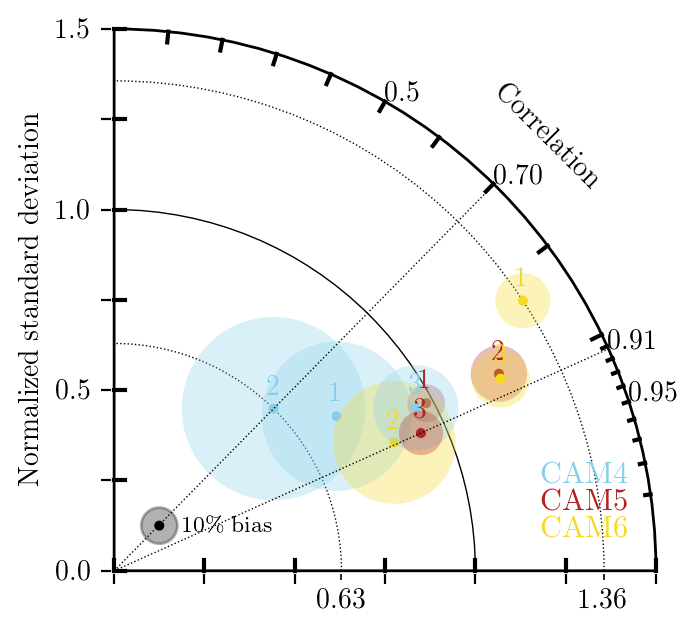

In [31]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick','#f6d921')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False

## Panel 4 (MISR low-topped thick and MODIS high-topped thick cloud)

### Open files

In [32]:
# original observations from the Kay 2012 paper
og_dir = '/glade/u/home/jonahshaw/w/kay2012_OGfiles'

In [33]:
og_clmisr = xr.open_dataset('%s/MISR.CLDLOW_THICK_MISR.nc' % (og_dir))
og_clmodis = xr.open_dataset('%s/MODIS.CLDHGH_THICK_MODIS.nc' % (og_dir))

In [34]:
og_clmisr = og_clmisr.rename({'CLDLOW_THICK_MISR':'CLDTHCK_MISR'})
og_clmodis = og_clmodis.rename({'CLDHGH_THICK_MODIS':'CLDTHCK_MODIS'})

#### Test with new MISR obs

It ends up working!

In [35]:
new_clmisr = xr.open_dataset('%s/2021_obs/%s' % (save_dir,'MISR_CLDTHCK_200003_202005.nc'))

og_clmisr = new_clmisr.rename({'clMISR':'CLDTHCK_MISR'})

#### Set-up

In [36]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'CLDTHCK_MISR': og_clmisr['CLDTHCK_MISR'], # these have to be dataarrays, not datasets
        'CLDTHCK_MODIS': og_clmodis['CLDTHCK_MODIS'],
    }

In [44]:
# suffixes = ['atm/proc/tseries/month_1','','atm/proc/tseries/month_1']
# paths to use if I have pr

_vars = ['CLDTHCK_MISR','CLDTHCK_MODIS']
_sdir = '/glade/u/home/jonahshaw/w/archive/taylor_files/'
model_das = {}
# for j,_dir in zip(_vars,case_dirs):
for j in _vars:
    print(j)
    var_files = []
    for ii in cases:
        print(ii)
        _f = glob.glob('%s/%s/*.%s.*' % (save_dir,ii,j)) # get the correct file
        # open dataset
        _ds = xr.open_dataset(_f[0])
        
        # Fix any weird month/year mismatch by weighting months equally.
        _da = _ds[j].groupby('time.month').mean('time').mean('month')
        # Interpolate to the control (observation) grid
        _da = _da.interp_like(cntlnames[j],method='linear')
#         _da = _da.interp_like(cntlnames[j])
        var_files.append(_da)
    model_das[j] = var_files

CLDTHCK_MISR
cam4_1deg_release_amip
cam5_1deg_release_amip


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1
CLDTHCK_MODIS
cam4_1deg_release_amip
cam5_1deg_release_amip
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1


### Calculate

#### These are not being masked correctly. Should just use values below 60degrees.

In [45]:
# Case names
testnames = ('CAM4','CAM5','CAM6')
testmetrics = model_das

varnames = ['CLDTHCK_MISR','CLDTHCK_MODIS']

nvars = 2; ntest = 3;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric #[var]
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio,_bias_abs = calculate(obs_ds,test_ds)
#         print(_bias[var],_corr[var],_rmsnorm[var],_ratio[var])
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

### Plot

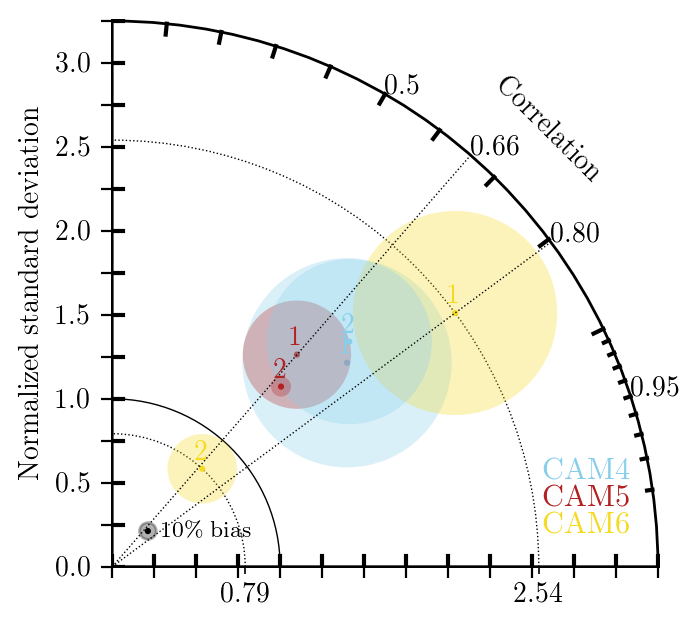

In [46]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick','#f6d921')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False

### Old

In [29]:
# start_dir = '/glade/u/home/jonahshaw/w/archive/taylor_files'

# for i in os.listdir(start_dir):
#     _path = '%s/%s' % (start_dir,i)
#     _file = os.listdir(_path)[0]
#     print(_file)
# #     print(os.listdir('%s/%s' % (start_dir,i)))
#     _temp = xr.open_dataset('%s/%s' % (_path,_file))
#     _temp = _temp.rename({'CLD_MISR':'CLDTOT_MISR'})
#     _temp.to_netcdf('%s/%s' % (_path,_file)+'1')

f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.CLDTHCK_MISR.nc
cam5_1deg_release_amip.CLDTHCK_MISR.nc
cam4_1deg_release_amip.CLDTHCK_MODIS.nc


ValueError: cannot rename 'CLD_MISR' because it is not a variable or dimension in this dataset